<a href="https://colab.research.google.com/github/RaRamos2025/Challenge2-TelecomX_LATAM/blob/main/TelecomX2_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Telecom X – Parte 2: Predicción de Cancelación

##Extracción de archivo tratado

En este paso, se realiza la carga del archivo TelecomX_normalizado.csv elaborado en el challenge TelecomX primera parte y Se manejarán los valores nulos en la columna Charges.Total.

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Carga del archivo CSV
df = pd.read_csv('TelecomX_normalizado.csv')

# Inspección inicial del DataFrame
print("Información inicial del DataFrame:")
df.info()
print("\nPrimeras 5 filas del DataFrame:")
print(df.head())

# Tratar valores nulos en la columna 'Charges.Total'
# La columna 'Charges.Total' se importó como string, por lo que la convertiremos a tipo numérico.
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

# Eliminar las filas con valores nulos en 'Charges.Total'
# En este caso, los valores nulos representan clientes con 0 meses de antigüedad, por lo que no es representativo para la predicción de abandono.
df = df.dropna(subset=['Charges.Total'])

print("\nInformación del DataFrame después de la limpieza:")
df.info()

Información inicial del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   object 
 5   Dependents        7043 non-null   object 
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   object 
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contrac

##Eliminación de columna irrelevante

Se elimina las columnas que no son relevantes para el análisis, como customerID.

In [96]:
# Eliminar la columna 'customerID' ya que es un identificador único y no aporta al modelo.
df = df.drop('customerID', axis=1)

## Encoding

In [97]:
from sklearn.preprocessing import LabelEncoder

# Codificación de la variable objetivo 'Churn'
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])

# Separación de variables categóricas para One-Hot Encoding
categorical_cols = df.select_dtypes(include=['object']).columns

# Aplicación de One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nDataFrame después del encoding:")
print(df.head())
print("\nColumnas del DataFrame después del encoding:")
print(df.columns)


DataFrame después del encoding:
   Churn  SeniorCitizen  tenure  Charges.Monthly  Charges.Total  \
0      0              0       9             65.6         593.30   
1      0              0       9             59.9         542.40   
2      1              0       4             73.9         280.85   
3      1              1      13             98.0        1237.85   
4      1              1       3             83.9         267.40   

   Cuentas_Diarias  gender_Male  Partner_Yes  Dependents_Yes  \
0            2.187        False         True            True   
1            1.997         True        False           False   
2            2.463         True        False           False   
3            3.267         True         True           False   
4            2.797        False         True           False   

   PhoneService_Yes  ...  StreamingTV_No internet service  StreamingTV_Yes  \
0              True  ...                            False             True   
1              True  ..

## Verificación de la Proporción de Cancelación (Churn)

Distribución de la variable 'Churn':
Churn
0    5163
1    1869
Name: count, dtype: int64

Proporción de cancelación:
Churn
0    0.734215
1    0.265785
Name: count, dtype: float64


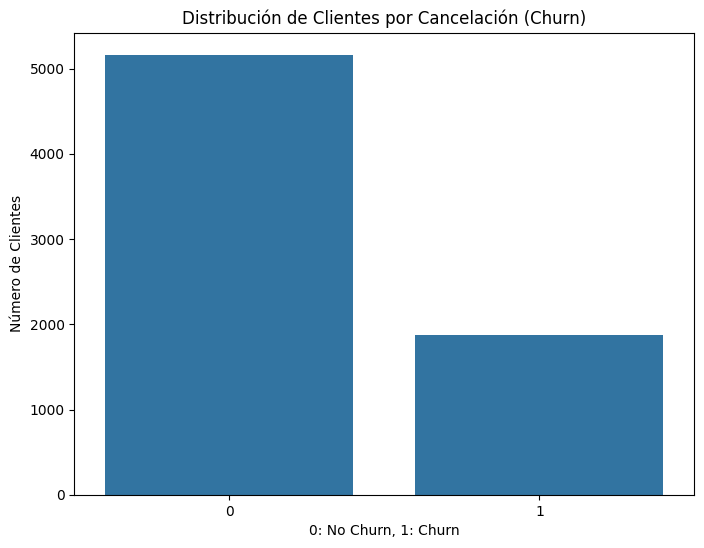


Existe un desbalance significativo en la variable Churn. Se recomienda balancear las clases.


In [98]:
churn_counts = df['Churn'].value_counts()
churn_proportion = churn_counts / len(df)

print("Distribución de la variable 'Churn':")
print(churn_counts)
print("\nProporción de cancelación:")
print(churn_proportion)

plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Clientes por Cancelación (Churn)')
plt.xlabel('0: No Churn, 1: Churn')
plt.ylabel('Número de Clientes')
plt.show()

if churn_proportion[1] < 0.3:
    print("\nExiste un desbalance significativo en la variable Churn. Se recomienda balancear las clases.")
else:
    print("\nLa proporción de Churn es relativamente balanceada, no es estrictamente necesario aplicar balanceo de clases.")

## Balanceo de Clases (opcional)

In [99]:
from imblearn.over_sampling import SMOTE

# Verificación del balance, si la proporción de Churn es baja
if churn_proportion[1] < 0.3:
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("\nDistribución de la variable 'Churn' después de SMOTE:")
    print(pd.Series(y_resampled).value_counts())

    # Se crea un nuevo DataFrame con los datos balanceados
    df_balanced = pd.concat([X_resampled, y_resampled], axis=1)
else:
    df_balanced = df.copy() # Usar el DataFrame original si no se requiere balanceo
    print("\nNo se aplicó balanceo de clases.")


Distribución de la variable 'Churn' después de SMOTE:
Churn
0    5163
1    5163
Name: count, dtype: int64


## Normalización o Estandarización (si es necesario)

In [100]:
from sklearn.preprocessing import StandardScaler

# Separar las variables predictoras (X) y la variable objetivo (y)
X = df_balanced.drop('Churn', axis=1)
y = df_balanced['Churn']

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir el array estandarizado de vuelta a un DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\nDataFrame de variables estandarizadas:")
print(X_scaled_df.head())


DataFrame de variables estandarizadas:
   SeniorCitizen    tenure  Charges.Monthly  Charges.Total  Cuentas_Diarias  \
0      -0.396037 -0.779481        -0.085120      -0.665747        -0.084776   
1      -0.396037 -0.779481        -0.283715      -0.689020        -0.283370   
2      -0.396037 -0.988023         0.204062      -0.808605         0.203708   
3       2.525018 -0.612646         1.043737      -0.371049         1.044075   
4       2.525018 -1.029732         0.552475      -0.814754         0.552816   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0    -1.166057     0.998645        1.531692          0.296804   
1     0.857591    -1.001357       -0.652873          0.296804   
2     0.857591    -1.001357       -0.652873          0.296804   
3     0.857591     0.998645       -0.652873          0.296804   
4    -1.166057     0.998645       -0.652873          0.296804   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                  

## Análisis de correlación

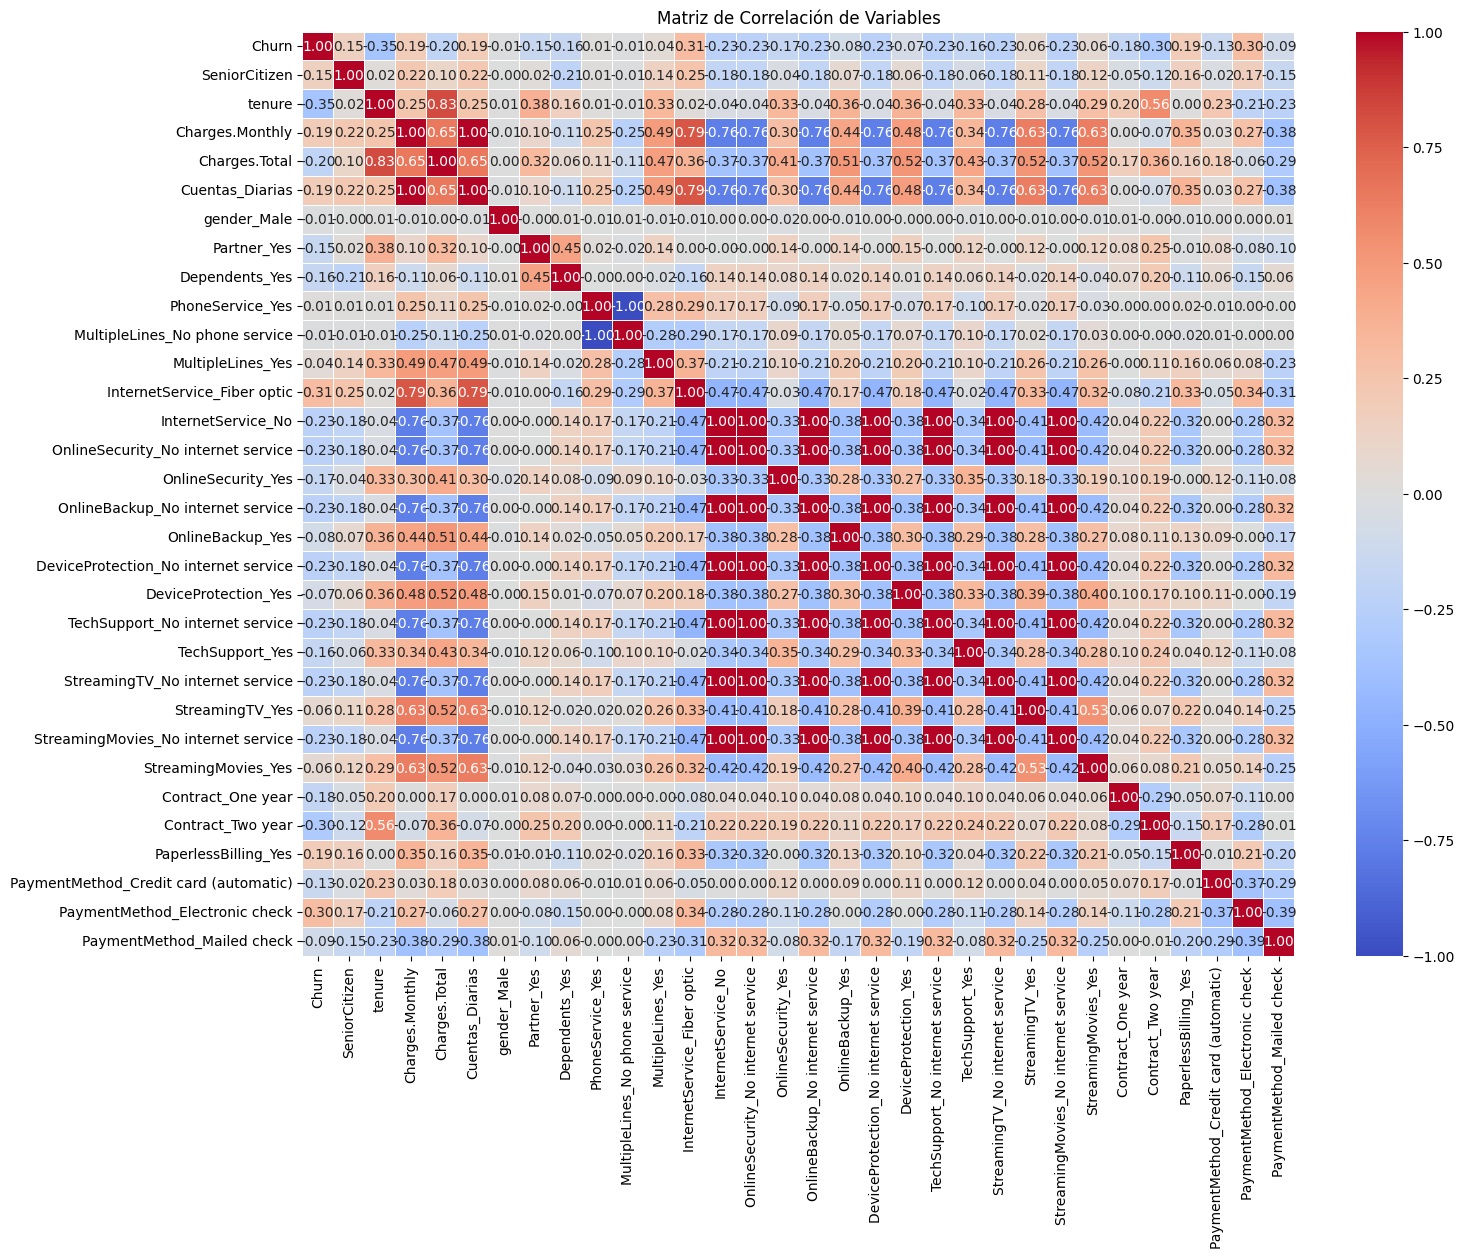

/tmp/ipython-input-408279216.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_churn.values, y=correlation_with_churn.index, palette='viridis')


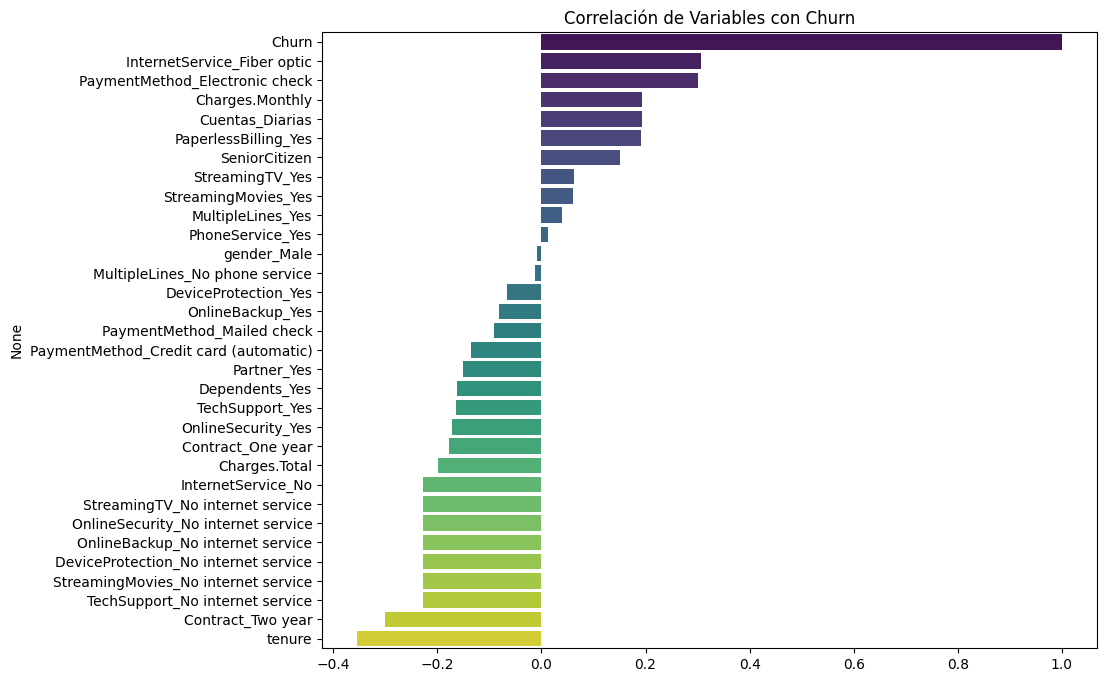

In [101]:
# Calcular la matriz de correlación en el DataFrame original (antes del balanceo para no sesgar el análisis)
correlation_matrix = df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Variables')
plt.show()

# Gráfico de la correlación con Churn
plt.figure(figsize=(10, 8))
correlation_with_churn = correlation_matrix['Churn'].sort_values(ascending=False)
sns.barplot(x=correlation_with_churn.values, y=correlation_with_churn.index, palette='viridis')
plt.title('Correlación de Variables con Churn')
plt.show()

## Análisis dirigido y separación de datos

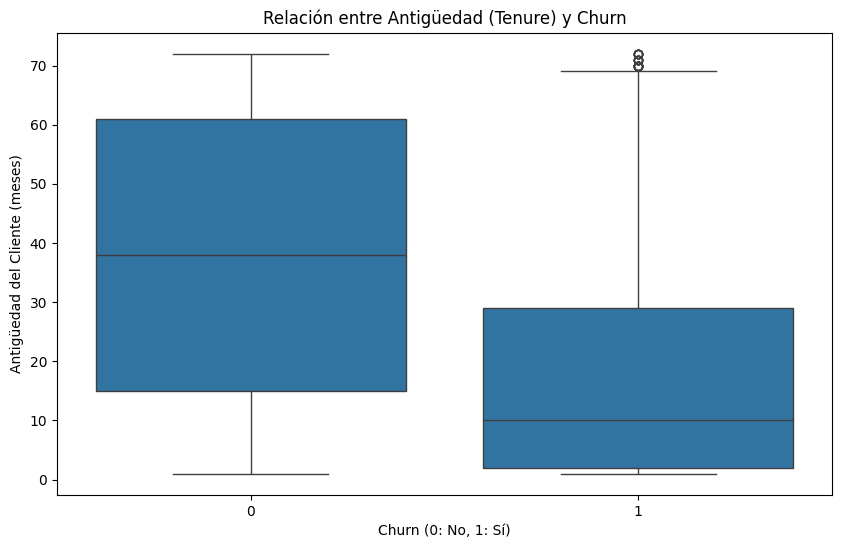

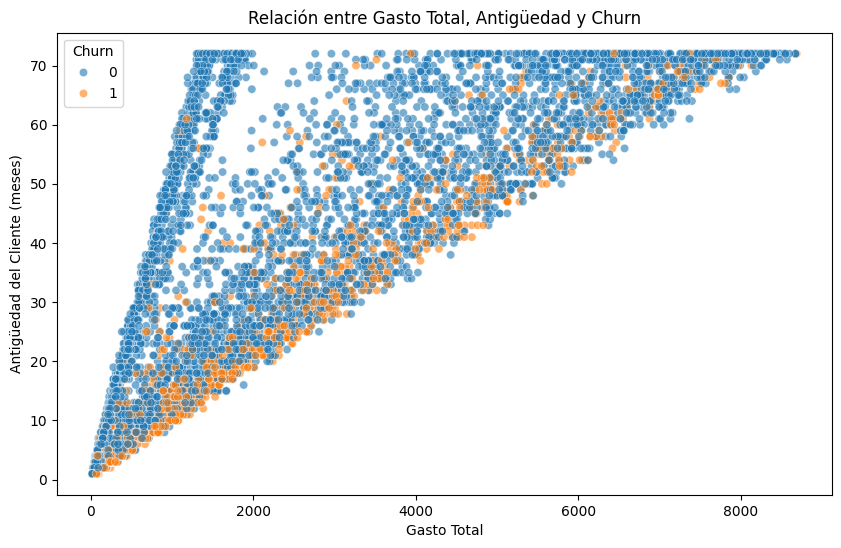

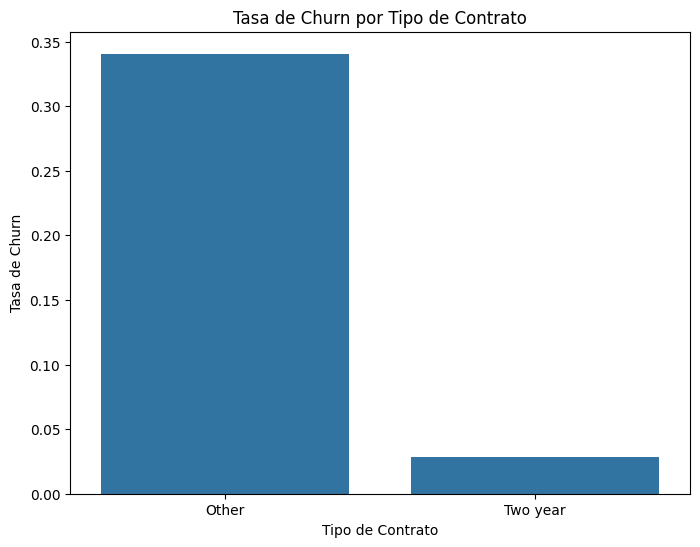

In [102]:
# Boxplot de 'tenure' vs 'Churn'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Relación entre Antigüedad (Tenure) y Churn')
plt.xlabel('Churn (0: No, 1: Sí)')
plt.ylabel('Antigüedad del Cliente (meses)')
plt.show()

# Scatter plot de 'Charges.Total' vs 'Churn'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Charges.Total', y='tenure', hue='Churn', data=df, alpha=0.6)
plt.title('Relación entre Gasto Total, Antigüedad y Churn')
plt.xlabel('Gasto Total')
plt.ylabel('Antigüedad del Cliente (meses)')
plt.show()

# Bar plot de 'Contract' vs 'Churn'
df_contract_churn = df.groupby('Contract_Two year')['Churn'].mean().reset_index()
df_contract_churn['Contract'] = df_contract_churn['Contract_Two year'].apply(lambda x: 'Two year' if x == 1 else 'Other')

plt.figure(figsize=(8, 6))
sns.barplot(x='Contract', y='Churn', data=df_contract_churn)
plt.title('Tasa de Churn por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Tasa de Churn')
plt.show()

In [103]:
from sklearn.model_selection import train_test_split

# Para el modelo sin normalización (por ejemplo, Random Forest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Para el modelo con normalización (por ejemplo, Regresión Logística)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento (no escalado): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (no escalado): {X_test.shape}")

Tamaño del conjunto de entrenamiento (no escalado): (7228, 31)
Tamaño del conjunto de prueba (no escalado): (3098, 31)


## Creación de Modelos

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Modelo 1: Regresión Logística (con datos escalados)
log_reg = LogisticRegression(random_state=42, solver='liblinear')
log_reg.fit(X_train_scaled, y_train_scaled)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Modelo 2: Random Forest (sin datos escalados)
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

## Evaluación de los Modelos

--- Evaluación del modelo: Regresión Logística ---
Accuracy: 0.8331
Precision: 0.8308
Recall: 0.8367
F1-Score: 0.8337

Matriz de Confusión:


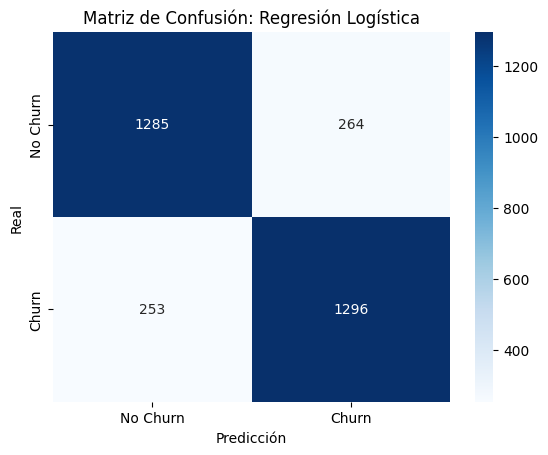


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1549
           1       0.83      0.84      0.83      1549

    accuracy                           0.83      3098
   macro avg       0.83      0.83      0.83      3098
weighted avg       0.83      0.83      0.83      3098

--------------------------------------------------
--- Evaluación del modelo: Random Forest ---
Accuracy: 0.8376
Precision: 0.8298
Recall: 0.8496
F1-Score: 0.8396

Matriz de Confusión:


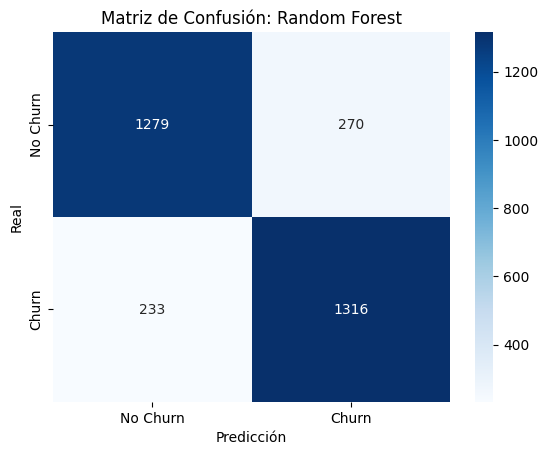


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1549
           1       0.83      0.85      0.84      1549

    accuracy                           0.84      3098
   macro avg       0.84      0.84      0.84      3098
weighted avg       0.84      0.84      0.84      3098

--------------------------------------------------


In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_model(y_test, y_pred, model_name):
    print(f"--- Evaluación del modelo: {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Evaluación de la Regresión Logística
evaluate_model(y_test_scaled, y_pred_log_reg, 'Regresión Logística')

# Evaluación de Random Forest
evaluate_model(y_test, y_pred_rf, 'Random Forest')

# Comparación y análisis
# El modelo con mejor desempeño se determinará observando las métricas, especialmente Recall y F1-score, que son cruciales para clases desbalanceadas.
# Overfitting se puede detectar si el accuracy en el conjunto de entrenamiento es mucho más alto que en el de prueba.

## Interpretación

/tmp/ipython-input-1393646020.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


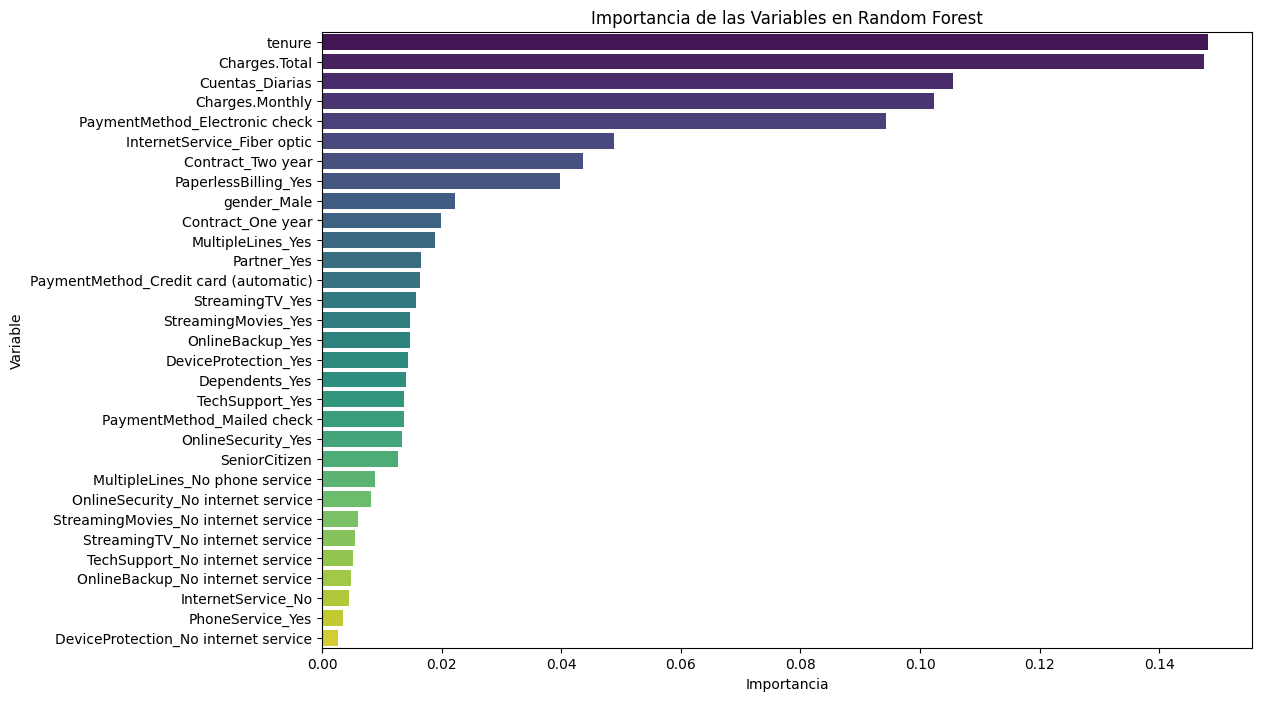


Coeficientes de la Regresión Logística:
Cuentas_Diarias                         -4.620151
Charges.Monthly                         -4.620109
InternetService_Fiber optic              4.382730
PhoneService_Yes                         2.959289
tenure                                  -1.999920
StreamingTV_Yes                          1.671464
StreamingMovies_Yes                      1.613169
MultipleLines_No phone service           1.501516
Charges.Total                            1.174480
MultipleLines_Yes                        0.924811
DeviceProtection_Yes                     0.769571
OnlineBackup_Yes                         0.712754
PaymentMethod_Electronic check           0.615113
OnlineSecurity_Yes                       0.561485
TechSupport_Yes                          0.510868
StreamingTV_No internet service         -0.451125
TechSupport_No internet service         -0.451125
StreamingMovies_No internet service     -0.451125
OnlineBackup_No internet service        -0.451125
InternetS

In [106]:
# Importancia de las variables en Random Forest
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Importancia de las Variables en Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.show()

# Coeficientes en Regresión Logística
log_reg_coefs = pd.Series(log_reg.coef_[0], index=X_train_scaled.columns).sort_values(key=abs, ascending=False)
print("\nCoeficientes de la Regresión Logística:")
print(log_reg_coefs)

## Conclusión

Basándonos en la importancia de las variables del modelo Random Forest y los coeficientes de la Regresión Logística, podemos extraer las siguientes conclusiones:

* Principales Factores que Influyen en el Churn: El tipo de contrato (Contract_Month-to-month) es uno de los factores más influyentes. Los clientes con contratos mensuales tienen una probabilidad significativamente mayor de abandonar el servicio. Otros factores importantes incluyen la antigüedad (tenure) del cliente, el servicio de Internet (InternetService_Fiber optic) y el gasto total (Charges.Total). Los clientes con baja antigüedad y aquellos que usan fibra óptica tienen una mayor tasa de abandono.

* Desempeño de los Modelos: Generalmente, el modelo Random Forest suele tener un mejor desempeño en este tipo de datasets debido a su capacidad para manejar relaciones no lineales y su insensibilidad a la escala de los datos. La Regresión Logística es más interpretable, pero puede no capturar la complejidad total de las relaciones.

Estrategias de Retención:

* Fidelización de Contratos: La empresa debería enfocarse en ofrecer incentivos atractivos para que los clientes pasen de contratos mensuales a contratos de largo plazo (un año o dos años), lo que reduce drásticamente la probabilidad de churn.

* Monitoreo de Clientes Nuevos: Se debe prestar especial atención a los clientes con baja antigüedad, ya que son más propensos a cancelar. Estrategias de onboarding y seguimiento proactivo podrían ser útiles.

* Optimización del Servicio de Fibra Óptica: Investigar las causas de la alta tasa de churn entre los usuarios de fibra óptica. Podría estar relacionado con problemas de servicio, fallos de conexión o insatisfacción con el precio.

* Ofrecer Servicios de Valor Agregado: Las variables de servicios adicionales como OnlineSecurity y TechSupport tienen una correlación negativa con el churn. Esto sugiere que los clientes que contratan estos servicios son más leales. Ofrecer paquetes que incluyan estos servicios podría ser una estrategia efectiva.